# **PEML MLP 2**
### Architecture 2 - PINN
Multi cities

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a Optuna hyperparameters optimisation and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.

## **IMPORTANT NOTE**: 
- do preprocessing from ``preprocess.ipynb`` to obtain data in ``data/data_combined``, before starting this notebook
- make sure the notebook is under ``src`` directory before running!
- change the global variables defined below for the desired years of data, loss function and NN type



In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *
from modelling.physics import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import pickle

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress




## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
all other variables are defined in config.py

LOSS_FUNC: choose from 
- MSE
- LinearShift_MSE
- PDE_nmer_const
- PDE_nmer_piece
- PINN

In [7]:
# Change this according to the data you want to use
YEARS = [2017, 2018, 2020, 2021, 2022, 2023]
TRAIN_YEARS = [2017, 2018, 2020, 2021, 2022]
VAL_YEARS = [2021, 2022, 2023]
TEST_YEARS = [2021, 2022, 2023]

LOSS_FUNC = "PINN"
NN_TYPE = "MLP"
CITY = 'Multi' 

## Automated Generation of paths and filenames according to data years, loss func, NN type
- will be used throughout the whole notebook
- check ``config.py`` for global variables defined outside the notebook

In [8]:
years, idx_dict , station_names, main_station, RESULTS_PATH, MODEL_PATH, DATASET_PATH, MINMAX_PATH, Y_PHY_FILENAME,  MODEL_PATH_NAME,RESULTS_METRICS_FILENAME, BESTPARAMS_FILENAME, PLOT_FILENAME  = init_paths(CITY, YEARS, LOSS_FUNC, NN_TYPE)
print("years: ", years)
print("idx_dict: ", idx_dict)
print("station_names: ", station_names)
print("main_station: ", main_station)
print("RESULTS_PATH: ", RESULTS_PATH)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("Y_PHY_FILENAME: ", Y_PHY_FILENAME)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

years:  allyears
idx_dict:  {'NO2_TUINDORP_IDX': 7, 'NO2_BREUKELEN_IDX': 4, 'NO2_OUDEMEER_IDX': 6, 'NO2_ZEGVELD_IDX': 8, 'NO2_KANTERSHOF_IDX': 5, 'WIND_DIR_IDX': 0, 'WIND_SPEED_IDX': 2}
station_names:  ['tuindorp', 'breukelen', 'zegveld', 'oudemeer', 'kantershof']
main_station:  breukelen
RESULTS_PATH:  /home/rachel/forecasting_smog_PEML/src/results/Multi
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/Multi/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/Multi/all_years/pollutants_minmax_allyears.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/Multi/all_years
Y_PHY_FILENAME:  y_phy_batchsize16_PINN_allyears_Multi
MODEL_PATH_NAME:  best_MLP_no2_PINN_allyears_Multi.pth
RESULTS_METRICS_FILENAME:  results_MLP_no2_PINN_allyears_Multi.csv
BESTPARAMS_FILENAME:  best_params_MLP_no2_PINN_allyears_Multi.txt
PLOT_FILENAME:  plot_MLP_no2_PINN_allyears_Multi.png


### **Load in data and create PyTorch *Datasets***

In [9]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2018_combined_u.csv
Imported train_2020_combined_u.csv
Imported train_2021_combined_u.csv
Imported train_2022_combined_u.csv
Imported train_2017_combined_y.csv
Imported train_2018_combined_y.csv
Imported train_2020_combined_y.csv
Imported train_2021_combined_y.csv
Imported train_2022_combined_y.csv
Imported val_2021_combined_u.csv
Imported val_2022_combined_u.csv
Imported val_2023_combined_u.csv
Imported val_2021_combined_y.csv
Imported val_2022_combined_y.csv
Imported val_2023_combined_y.csv
Imported test_2021_combined_u.csv
Imported test_2022_combined_u.csv
Imported test_2023_combined_u.csv
Imported test_2021_combined_y.csv
Imported test_2022_combined_y.csv
Imported test_2023_combined_y.csv
Successfully loaded data


In [10]:
train_input_frames

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.187615   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.126867   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.228226   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.343011   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.385719   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.182245   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.196929   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.200201   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.189377   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [11]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

## Confirmation that the dataset has column indexes the same as those in ``config.py``
Indexes are used mainly for the physics calculations, in order to accurately extract the information needed

In [12]:
column_names = list(train_dataset.u[0])  # Convert Index to list
check_station_indexes(column_names, idx_dict)

NO2_TUINDORP_IDX index matches in index: 7
NO2_BREUKELEN_IDX index matches in index: 4
NO2_OUDEMEER_IDX index matches in index: 6
NO2_ZEGVELD_IDX index matches in index: 8
NO2_KANTERSHOF_IDX index matches in index: 5
WIND_DIR_IDX index matches in index: 0
WIND_SPEED_IDX index matches in index: 2
All station indexes match.


True

## Tuning Hyperparameters with Optuna

In [13]:
print("tuning with loss function: ", LOSS_FUNC)
print("tuning with nn type: ", NN_TYPE)

tuning with loss function:  PINN
tuning with nn type:  MLP


In [14]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:

def objective(trial):
    # Define hyperparameters to search over
    set_seed(42)
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)
    lambda_ic = trial.suggest_loguniform("lambda_ic", 1e-5, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss, _, _, _ = model.train_model(
        train_loader, val_loader, epochs=50,
        lr=lr, weight_decay=weight_decay,
        lambda_phy=lambda_phy,
        lambda_ic=lambda_ic,
        device=device,
        trial=trial,
        idx_dict=idx_dict,
        station_names=station_names,
        main_station=main_station
    )

    return val_loss



# Run Optuna optimization
study = optuna.create_study(
    direction="minimize", 
    study_name="mlp_hyperparameter_optimization_PINN_multi_newpde", 
    storage="sqlite:///mlp_hyperparameter_optimization_phy_pde.db", 
    load_if_exists=True,
    pruner=optuna.pruners.HyperbandPruner(),
    )

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
print(f"Best Hyperparameters for {NN_TYPE} with {LOSS_FUNC} for {years}:\n", best_params)

## Save the params to a file
Parameters saved in ``src/results/best_params/best_params_MLP_no2_PINN_allyears.txt``

In [16]:
import json
best_params_file_path = f"{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}"

In [ ]:
print("Best parameters file path: ", best_params_file_path)

Best parameters file path:  /home/rachel/forecasting_smog_PEML/src/results/Multi/best_params/best_params_MLP_no2_PINN_allyears_Multi.txt


In [ ]:
with open(best_params_file_path, "w") as f:
    json.dump(best_params, f, indent=4)  # Pretty format for readability

print(f"Best Hyperparameters saved to {best_params_file_path}")


Best Hyperparameters saved to /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_PINN_allyears.txt


## Read params from file

In [17]:
with open(best_params_file_path, "r") as f:
    best_params = json.load(f)  # Automatically converts it to a dictionary

print("Loaded Best Parameters:", best_params)


Loaded Best Parameters: {'n_hidden_layers': 3, 'n_hidden_units': 252, 'lr': 4.500039019535873e-05, 'weight_decay': 4.599161181117004e-07, 'lambda_phy': 0.0007031291303903508, 'batch_size': 64}


In [24]:
best_params = {
    "n_hidden_layers": 3,
    "n_hidden_units": 252,
    "lr": 4.500039019535873e-05,
    "weight_decay": 1.599161181117004e-07,
    "lambda_phy": 0.00007031291303903508,
    "batch_size": 64
}

## Training and Saving Model
Model saved in ``src/results/models/best_MLP_no2_PINN_allyears.pth``

In [ ]:
set_seed(42)
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
_, training_time, train_losses, val_losses = best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], 
                                                                    weight_decay=best_params["weight_decay"], lambda_phy= best_params['lambda_phy'],device=device, 
                                                                    idx_dict= idx_dict, station_names = station_names, main_station = main_station)
print(f"Training time: {training_time}")
# Save the trained model
# torch.save(best_model.state_dict(), f"{MODEL_PATH}/{MODEL_PATH_NAME}")
# print(f"Model saved as {MODEL_PATH_NAME} in Model folder")

## Plot Train-Val
Plot saved in ``src/results/trainval_plots/trainval_plot_MLP_no2_PINN_allyears.png``


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.title(f"Training and Validation Loss Over Epochs for {NN_TYPE} with {LOSS_FUNC}")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"{RESULTS_PATH}/trainval_plots/trainval_{PLOT_FILENAME}")
plt.show()


## Test and Save Results
Results saved in ``src/results/metrics/results_MLP_no2_PINN_allyears.csv``

In [26]:
# best_model.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}", map_location=device))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device=device)



Test MSE Loss: 44.935375
Test RMSE Loss: 6.703385
Test SMAPE Loss: 26.392252%
Total Inference Time: 0.08 seconds


In [ ]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/metrics/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time", "Training Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time, training_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in Results/metrics folder")

## Plot Model predictions vs True values
Plot saved ``src/results/plots/plot_MLP_no2_PINN_allyears.png``

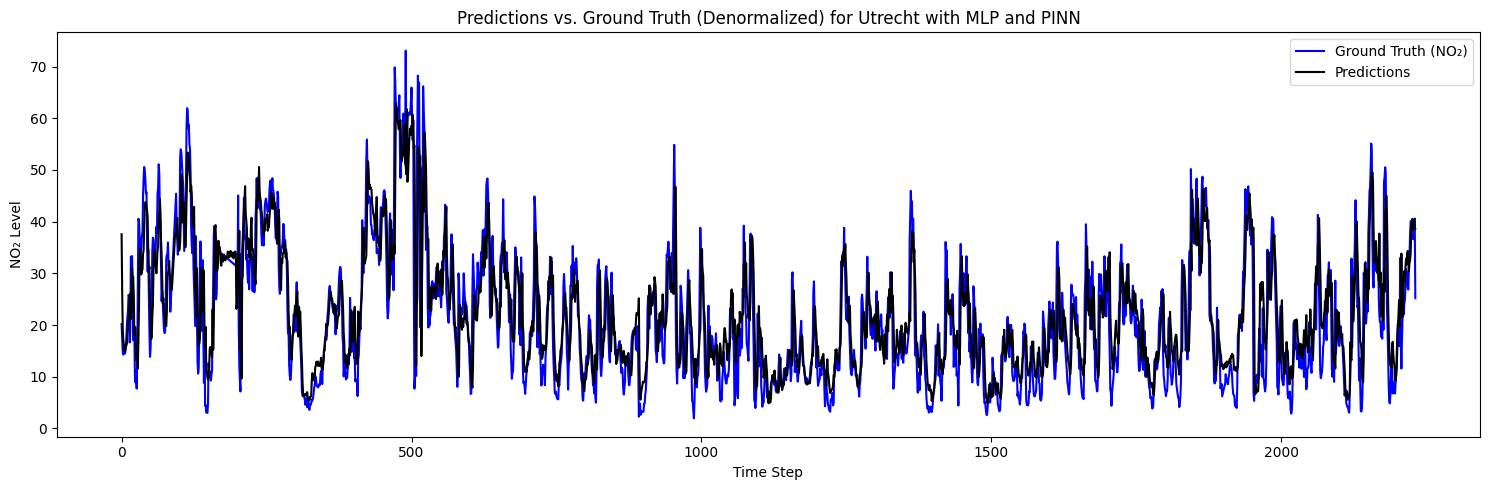

In [20]:
import torch 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load min and max values for denormalization
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = torch.tensor(df_minmax["min"].values, dtype=torch.float32)  # shape: (N_OUTPUT_UNITS,)
max_value = torch.tensor(df_minmax["max"].values, dtype=torch.float32)  # shape: (N_OUTPUT_UNITS,)

# Dynamically detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is on the right device and in eval mode
best_model.to(device)
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch
        x_test = x_test.to(device)
        y_true = y_true.to(device)

        # Get predictions
        y_pred = best_model(x_test)

        # Move to CPU and store
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Stack batches
y_preds = torch.cat(y_preds, dim=0)  # shape: (batch_size, n_hours_y, n_outputs)
y_trues = torch.cat(y_trues, dim=0)

# Denormalize
min_value = min_value.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, n_outputs)
max_value = max_value.unsqueeze(0).unsqueeze(0)
y_preds_denorm = y_preds * (max_value - min_value) + min_value
y_trues_denorm = y_trues * (max_value - min_value) + min_value

# Convert to numpy for plotting
y_preds_np = y_preds_denorm.numpy()
y_trues_np = y_trues_denorm.numpy()

# Plot 1 feature/channel (e.g., station 0)
feature_idx = 0
plt.figure(figsize=(15, 5))
plt.plot(y_trues_np[:, :, feature_idx].flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.plot(y_preds_np[:, :, feature_idx].flatten(), label="Predictions", linestyle="-", color="black")

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title(f"Predictions vs. Ground Truth (Denormalized) for Utrecht with {NN_TYPE} and {LOSS_FUNC}")
plt.legend()
plt.tight_layout()
# Save the plot
# plt.savefig(f"{RESULTS_PATH}/plots/{PLOT_FILENAME}")
plt.show()


In [ ]:
# === Plot 2: First 30 Days (720 Hours) ===
time_limit = 30 * 24
plt.figure(figsize=(15, 5))
plt.plot(y_trues_np[:, :, feature_idx].flatten()[:time_limit], label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.plot(y_preds_np[:, :, feature_idx].flatten()[:time_limit], label="Predictions", linestyle="-", color="black")
plt.xlabel("Time Step (First 30 Days)")
plt.ylabel("NO₂ Level")
plt.title(f"Predictions vs. Ground Truth (Denormalized) of first 30 days at Breukelen with Multiple Cities input using {NN_TYPE} and {LOSS_FUNC}")
plt.legend()
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/plots/plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}_{CITY}_30days.png")
plt.show()